# Band extraction for the EFT analysis calibration

This jupyter notebook has been developped to extract the CH3T, DD-gun and C14 bands for the LUX EFT analysis calibration. 
Before using this macro, please be sure that you pull all the data needed for this analysis by using either `getDataOnPDSF.sh` or `getDataFromPDSF.sh`. 

Contact: Q. Riffard (qriffard -at- lbl.gov)

## Imports

In [1]:
# Usefull path to add
import sys
sys.path.insert(2, 'common')

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt

import common_tools as tools
import extraction
import band_calculation


%matplotlib inline

Welcome to JupyROOT 6.14/02


## Data list and definition of the time bins and drift bins

In [9]:
# Path to the .npz data file
data_path = 'data/'

# If you want to extract the bands for a specific data set: comment the others.
data_list = []
data_list.append({'label': 'Run4 C14',  'name':'C14',  'run': 4,'filename': 'C14_Run04_peaks.npz'})
data_list.append({'label': 'Run4 DD',   'name':'DD',   'run': 4,'filename': 'DD_Run04_peaks_keep.npz'})
data_list.append({'label': 'Run4 CH3T', 'name':'CH3T', 'run': 4,'filename': 'CH3T_Run04_peaks.npz'})

# Definition of the time bins
time_bins = [(datetime.datetime(2014, 9, 9), datetime.datetime(2015, 1, 1)),
             (datetime.datetime(2015, 1, 1), datetime.datetime(2015, 4, 1)),
             (datetime.datetime(2015, 4, 1), datetime.datetime(2015, 10, 1)),
             (datetime.datetime(2015, 10, 1), datetime.datetime(2018, 10, 1))] # The end of the time bin #4 doesn't matter

# Definition of the drift bins
drift_bins = [(40, 105), (105, 170), (170, 235), (235, 300)]


# Si bin max value
all_s1_bin_max = {'Run4 C14':800, 'Run4 DD':100, 'Run4 CH3T':100}


## Extract the data

In [10]:
# Collect all the data into this dictionary
data_colection = {}

# list of RQs to save
rqs_to_save = ['S1_area_cor', 'S2_area_cor','S1_spiky_cor', 'S2_drift', 'luxstamp_date']

for meta in data_list:
    
    label = meta['label']
    filename =  meta['filename']
    name = meta['name']
    run = meta['run']
    s1_bin_max = all_s1_bin_max[label]
    
    
    filename = data_path + filename

    print('Extract',label, 'from', filename)

    data = dict(np.load(filename))

    # Apply field unit conversion from V/m to V/cm
    data = tools.applyUnitTransformation(data, keys_to_trans=['field'], trans_factor=[1/100.])

    # Convert the luxstamp into date time
    data['luxstamp_date'] = tools.luxstampToDate(data['luxstamp'])

    all_cuts = extraction.getDataCut(data, name, run)

    # Get the data with the cut applied
    data_cuted = tools.reduceData(data, all_cuts,rqs_to_save)

    # Build the S1 observable
    data_cuted['S1_obs'] = (data_cuted['S1_spiky_cor'] * (data_cuted['S1_area_cor'] < 120)) + (data_cuted['S1_area_cor'] * (data_cuted['S1_area_cor'] >= 120))


    # Get only the needed data
    data_out = {}
    
    data_out['s1'] = data_cuted['S1_obs']
    data_out['s2'] = data_cuted['S2_area_cor']
    data_out['luxstamp_date'] = data_cuted['luxstamp_date']
    data_out['tdrift'] = data_cuted['S2_drift']
    

    # Make the conversion to numpy array
    for key, val in data_out.items(): data_out[key] = np.array(val)
        
    # Add the merged data
    data_colection[label] = data_out
         
print('Extraction completed !!')

Extract Run4 C14 from data/C14_Run04_peaks.npz
Extract Run4 DD from data/DD_Run04_peaks_keep.npz
Extract Run4 CH3T from data/CH3T_Run04_peaks.npz
Extraction completed !!


## Extract the band for each time bin and each drift bin



In [11]:
band_collection = {}

for meta in data_list:
    
    label = meta['label']
    data = data_colection[label]
    
    data_s1 = data['s1']
    data_s2 = data['s2']
    data_luxstamp_date = data['luxstamp_date']
    data_tdrift = data['tdrift']
    s1_bin_max = all_s1_bin_max[label]
    
    band_collection[label] = {}
    
    for ibin, (time_min, time_max) in enumerate(time_bins):
        
        TB = 'Time bin {0}'.format(ibin+1)
        band_collection[label][TB] = {}
        
        for drift_min, drift_max in drift_bins:
            
            cut_time = (data_luxstamp_date > time_min) * (data_luxstamp_date < time_max)
            cut_drift = (data_tdrift > drift_min) * (data_tdrift < drift_max)
            
            cuts = cut_time * cut_drift
            
            if np.sum( cuts ) ==0: continue
            
            s1c_bins = np.linspace(0.5, s1_bin_max+.5, s1_bin_max + 1)
            band = band_calculation.getBand(data_s1[cuts], data_s2[cuts], s1c_bins, return_err=True, return_sigma=True)
            
            band_collection[label][TB]['{0} < tdrift < {1} us'.format(drift_min, drift_max)] = (band,s1_bin_max)
            
    #band_s1c, band_lq, band_lq_err, band_lq_sigma, band_lq_sigma_err

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
common/band_calculation.py:31: RuntimeWarning: divide by zero encountered in true_divide
  lq_data = np.log10(s2c_data / s1c_data)


## Do plots

[2.98458844 2.81165999 2.74932531 2.68330071 2.60018451 2.53187487
 2.48554498 2.45444354 2.42723267 2.40790972 2.37360793 2.34268868
 2.32542311 2.31396264 2.29424929 2.28275083 2.27043612 2.26194447
 2.24779555 2.23547873 2.23845311 2.21581822 2.21560573 2.20207935
 2.19710498 2.19298676 2.19552031 2.19301646 2.1757901  2.17337586
 2.16143932 2.15953668 2.15390657 2.14914377 2.15865391 2.13990863
 2.14719798 2.13818798 2.13720676 2.13926812 2.12980922 2.1228301
 2.11995611 2.11869247 2.1128315  2.11206232 2.11963625 2.11029216
 2.11362047 2.10033711 2.10006398 2.08856658 2.10470714 2.09857536
 2.09812613 2.10060775 2.08857196 2.08920799 2.09465963 2.08430001
 2.08584811 2.09092835 2.08010666 2.07960492 2.08198481 2.07591264
 2.0732966  2.08728814 2.07419939 2.07086445 2.07408336 2.07651506
 2.07883143 2.07131335 2.07541742 2.07397602 2.07273915 2.06672108
 2.07792941 2.0640728  2.06422173 2.06005684 2.06148004 2.05796931
 2.06528977 2.05944842 2.05577153 2.06239043 2.06598866 2.05818

[2.60793856 2.36882901 2.34586762 2.268013   2.20742827 2.17223204
 2.14516008 2.12409235 2.10135633 2.08556128 2.06600416 2.04810807
 2.0394131  2.01395515 2.00554085 1.99193785 1.97984899 1.95044992
 1.95540597 1.95985936 1.94566145 1.94041475 1.91922347 1.92398083
 1.88867463 1.8788066  1.88471329 1.85487346 1.88789729 1.87788481
 1.8633357  1.84980939 1.8481137  1.87009133 1.84037214 1.83831339
 1.82690829 1.8316108  1.80075895 1.82884501 1.80168579 1.81152235
 1.81921455 1.82811516 1.81372852 1.7982508  1.82497621 1.79642732
 1.76875418 1.78352697 1.78144877 1.78132639 1.73683599 1.7708417
 1.75422824 1.74420847 1.71898114 1.74878125 1.72446192 1.76524891
 1.7406635  1.74124823 1.75202275 1.71515746 1.71992797 1.7184068
 1.71386425 1.71403524 1.6965623  1.70198384 1.70160236 1.69549222
 1.69267908 1.67699884 1.65633223 1.68213364 1.66531643 1.68573771
 1.65720359 1.66786219 1.67087801 1.65291611 1.63455475 1.65482896
 1.64081285 1.63712991 1.63276393 1.63485339 1.61042935 1.619118

[3.16270778 2.81912795 2.76373057 2.68933641 2.60181146 2.53438931
 2.48714154 2.44892946 2.42285491 2.39609015 2.37415624 2.35063213
 2.33471952 2.30893116 2.29681824 2.28250209 2.26766442 2.25557806
 2.24552445 2.23387165 2.22560164 2.21649929 2.20588616 2.1964585
 2.19041159 2.18929126 2.18351249 2.17183167 2.15926994 2.16213105
 2.15506183 2.14727525 2.14294411 2.13996778 2.13247155 2.12956794
 2.1238881  2.12745472 2.11122397 2.11660045 2.11280549 2.10880821
 2.09833113 2.0920747  2.08270864 2.10113982 2.08348323 2.09294972
 2.08284595 2.0795489  2.07979645 2.07744203 2.0611206  2.0701991
 2.06431489 2.06378025 2.04184202 2.05369253 2.05072031 2.03813874
 2.03841962 2.03968353 2.02916579 2.03462084 2.02813749 2.00957132
 2.0191325  2.01066754 2.01669834 2.02299811 1.97870487 2.00069312
 1.99115994 1.98564652 1.99328158 1.97992279 1.96895948 1.97109328
 1.99052371 1.96134094 1.95323986 1.96677914 1.95296221 1.9564521
 1.93108715 1.92151084 1.94281645 1.88862978 1.91476497 1.9158130

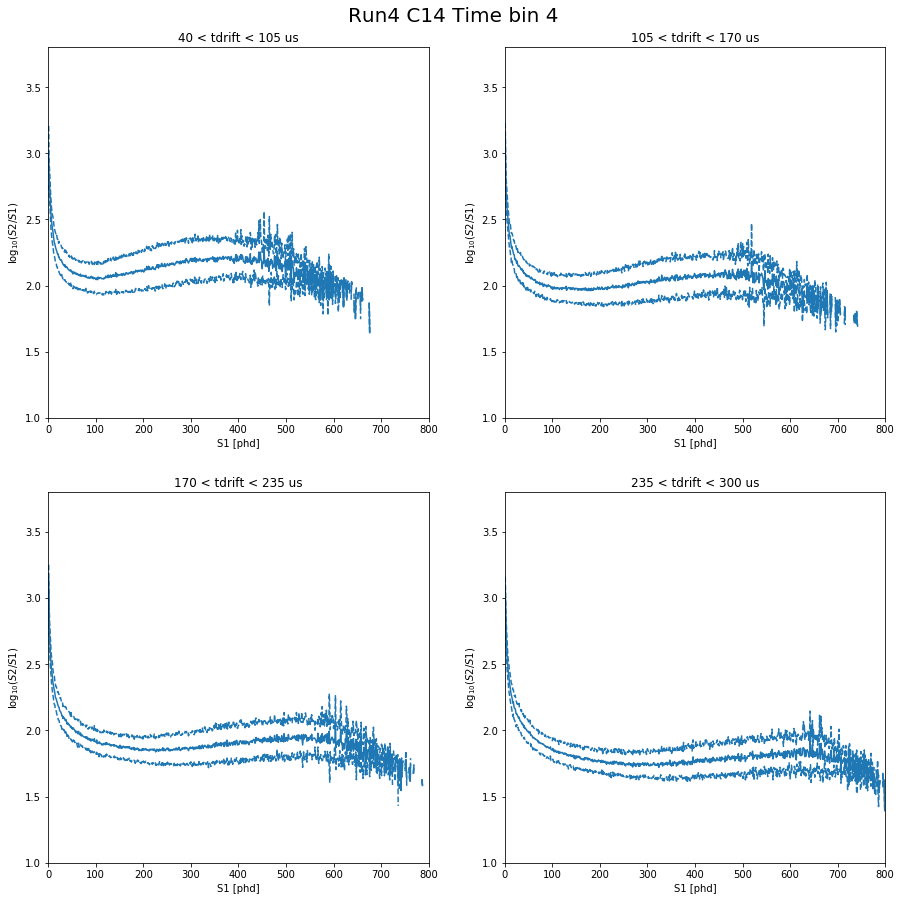

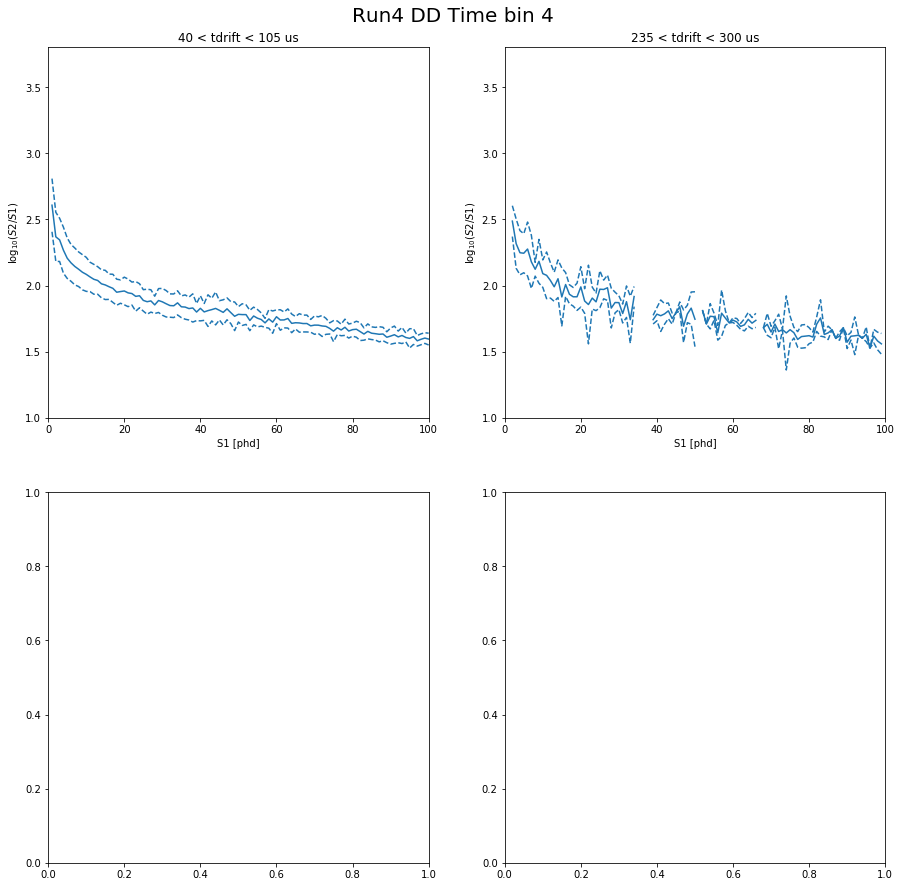

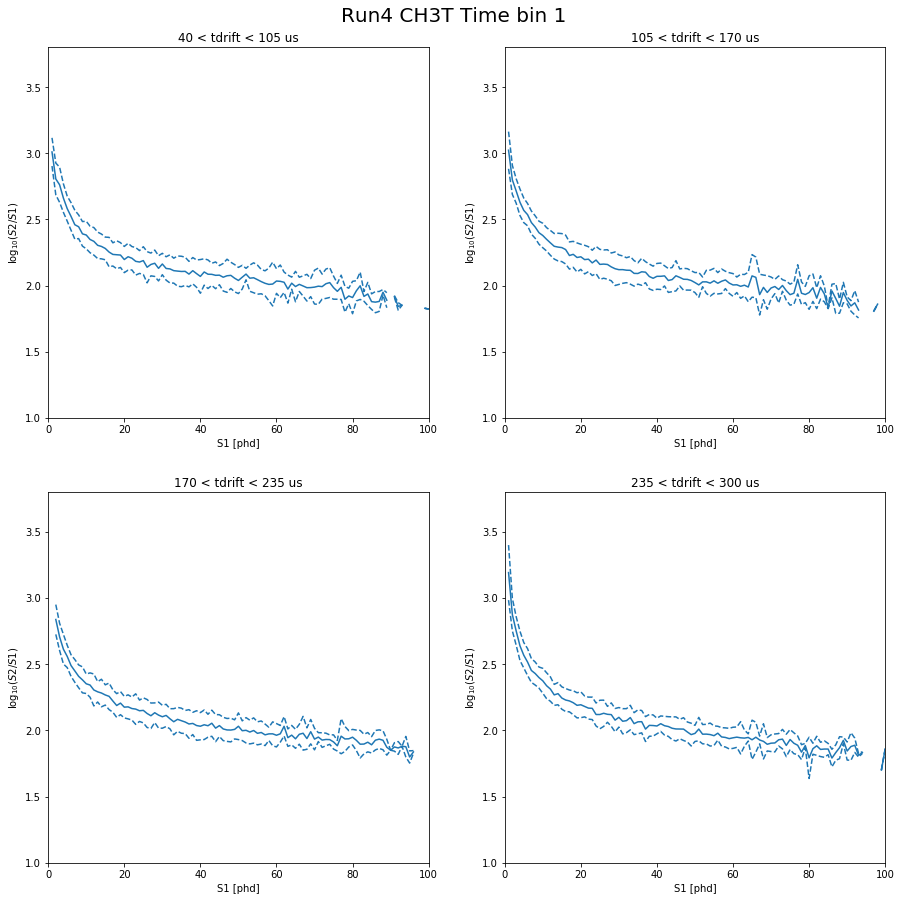

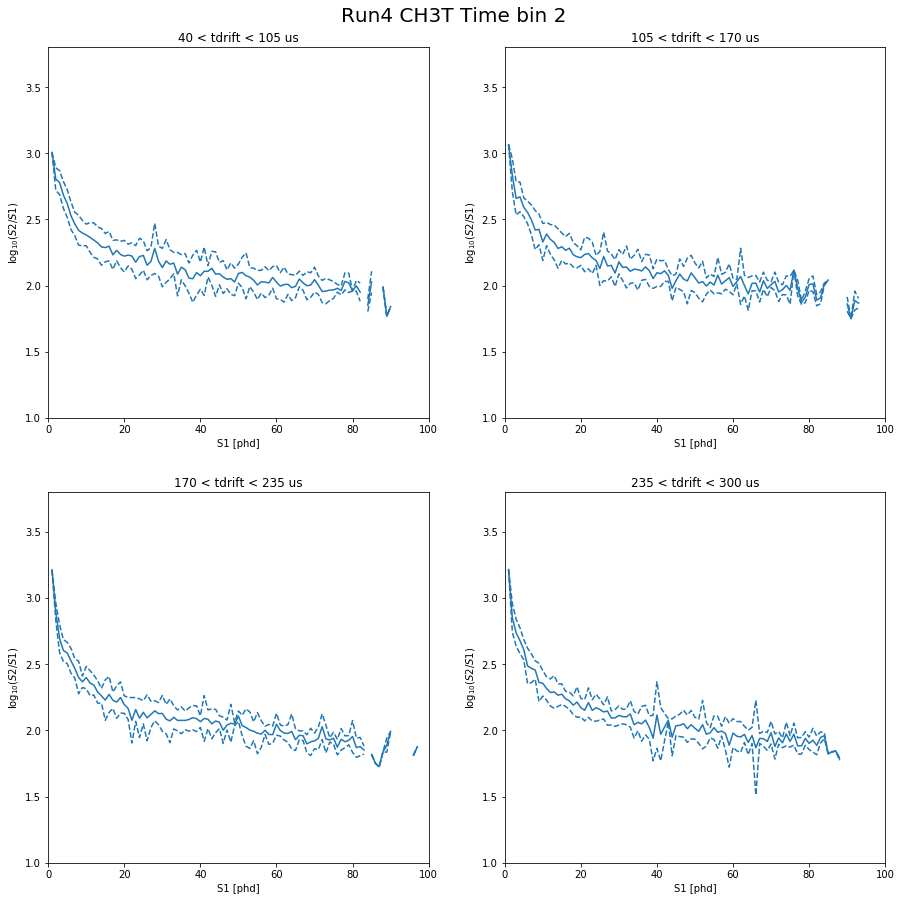

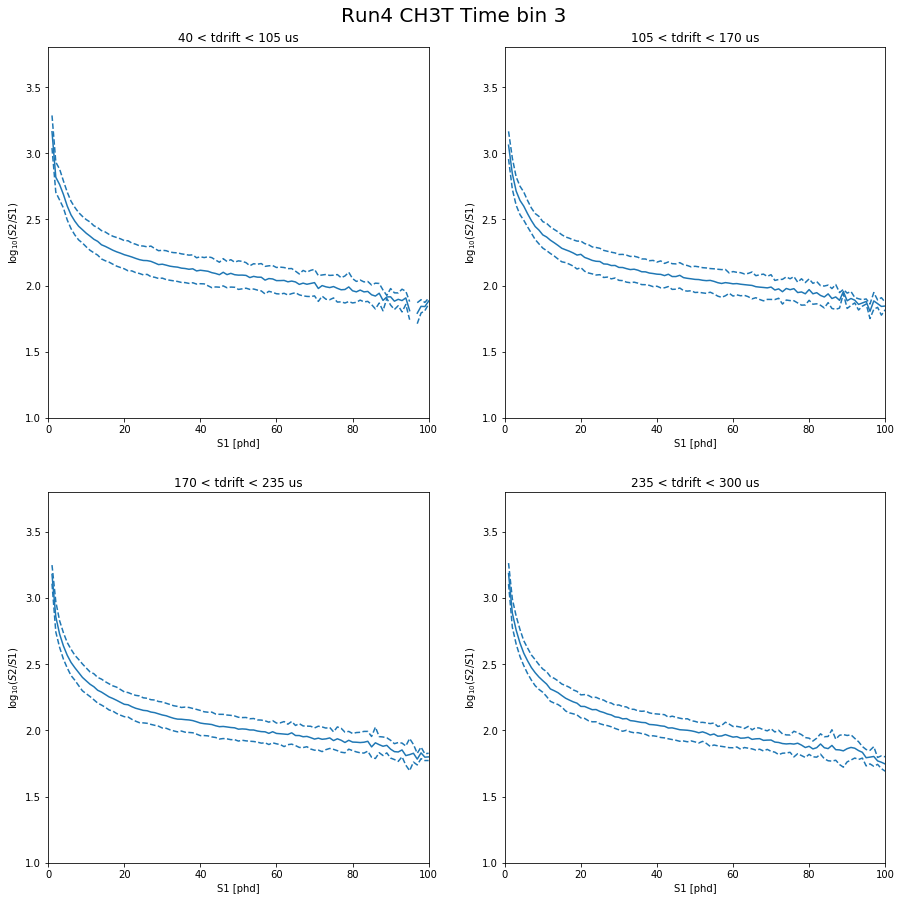

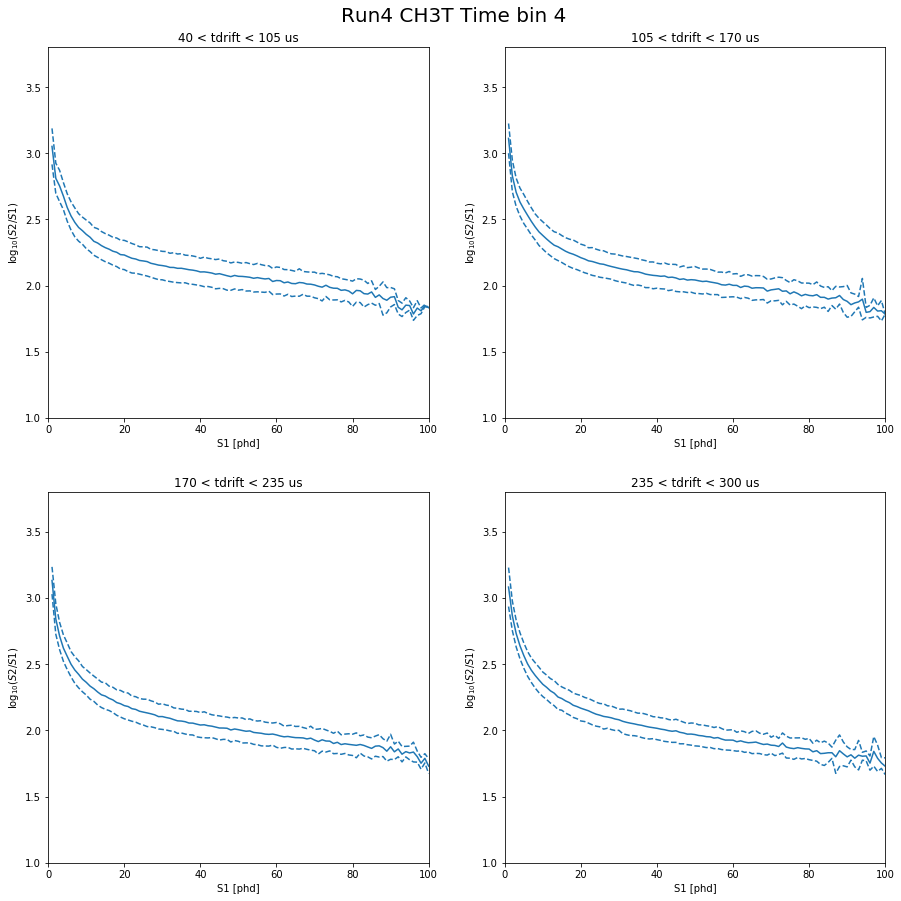

In [12]:
for label, band_TB in band_collection.items():
    
    s1_bin_max = all_s1_bin_max[label]
    
    for TB, band_TB_drift in band_TB.items():
                
        if len(band_TB_drift) == 0: continue
            
        fig_band, axes_band = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
        axes_band = axes_band.flatten()
            
        for index, (drift,
                    ((band_s1c, band_lq, band_lq_err,
                      band_lq_sigma, band_lq_sigma_err), s1_bin_max)) in enumerate(band_TB_drift.items()):

    
            axes_band[index].plot(band_s1c, band_lq, color='C0', label=label)
            axes_band[index].plot(band_s1c, band_lq + band_lq_sigma, color='C0', linestyle='dashed')        
            axes_band[index].plot(band_s1c, band_lq - band_lq_sigma, color='C0', linestyle='dashed')

            axes_band[index].set_title(drift)
            axes_band[index].set_xlim([0, s1_bin_max])
            axes_band[index].set_ylim([1, 3.8])
            axes_band[index].set_xlabel('S1 [phd]')
            axes_band[index].set_ylabel('$\log_{10}(S2/S1)$')
            
        fig_band.suptitle('{0} {1}'.format(label,TB), verticalalignment='bottom', y = 0.9, fontsize=20)
    

## Save the bands in output file

In [13]:
os.system('mkdir -p bands')

for label, band_TB in band_collection.items():
    
    s1_bin_max = all_s1_bin_max[label]
    
    for TB, band_TB_drift in band_TB.items():
                
        if len(band_TB_drift) == 0: continue
                
        for index, (drift,
                    ((band_s1c, band_lq, band_lq_err,
                      band_lq_sigma, band_lq_sigma_err), s1_bin_max)) in enumerate(band_TB_drift.items()):
    
            filename = 'bands/{0}_{1}_{2}.dat'.format(label, TB, drift)
            filename = filename.replace(' ', '_')
            filename = filename.replace('<', '')
            filename = filename.replace('__', '_')
            
            
            file = open(filename, 'w')
            file.write('Data set: {0}\n'.format(label))
            file.write('Time bin: {0}\n'.format(TB))
            file.write('Drift bin: {0}\n'.format(drift))
            file.write('s1c mean mean_err sigma sigma_err\n')
            
            
            for s1c, mean, mean_err, sigma, sigma_err in  zip(band_s1c, band_lq, band_lq_err, band_lq_sigma, band_lq_sigma_err):
                file.write('{0} {1} {2} {3} {4}\n'.format(s1c, mean, mean_err, sigma, sigma_err))
            
            file.close()
            
            print('Write the band', label, TB, drift, '......\n................... into', filename)

    

Write the band Run4 C14 Time bin 4 40 < tdrift < 105 us ......
................... into bands/Run4_C14_Time_bin_4_40_tdrift_105_us.dat
Write the band Run4 C14 Time bin 4 105 < tdrift < 170 us ......
................... into bands/Run4_C14_Time_bin_4_105_tdrift_170_us.dat
Write the band Run4 C14 Time bin 4 170 < tdrift < 235 us ......
................... into bands/Run4_C14_Time_bin_4_170_tdrift_235_us.dat
Write the band Run4 C14 Time bin 4 235 < tdrift < 300 us ......
................... into bands/Run4_C14_Time_bin_4_235_tdrift_300_us.dat
Write the band Run4 DD Time bin 4 40 < tdrift < 105 us ......
................... into bands/Run4_DD_Time_bin_4_40_tdrift_105_us.dat
Write the band Run4 DD Time bin 4 235 < tdrift < 300 us ......
................... into bands/Run4_DD_Time_bin_4_235_tdrift_300_us.dat
Write the band Run4 CH3T Time bin 1 40 < tdrift < 105 us ......
................... into bands/Run4_CH3T_Time_bin_1_40_tdrift_105_us.dat
Write the band Run4 CH3T Time bin 1 105 < tdrift 

![title](tada.jpg)